# Fused Layers in Triton

## Setup

In [1]:
%pip install --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly==3.0.0.post20240626041721

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"
os.environ["DISABLE_TORCH_COMPILE"] = "true"
os.environ["TRITON_PRINT_AUTOTUNING"] = "1"

Check the installed triton version.

In [3]:
import triton

assert triton.__version__ == "3.0.0", f"Expected Triton to have a version of 3.0.0, but found {triton.__version__}"

Import other needed stuff.

In [4]:
import torch
import triton.language as tl

Specify the autotune config.

In [5]:
def get_autotune_config():
    return [
        triton.Config({}, num_warps=1),
        triton.Config({}, num_warps=2),
        triton.Config({}, num_warps=4),
        triton.Config({}, num_warps=8),
        triton.Config({}, num_warps=16),
        triton.Config({}, num_warps=32),
    ]

## Baseline Specification

Recall that the RMSNorm is defined to be
$$
\frac{\mathbf{X}}{\mathrm{RMS}(\mathbf{X})}\odot \mathbf{G} + \mathbf{B}
$$
where $\mathbf{X}$ is the input tensor, $\mathbf{G}$ is the 'gain' tensor (gamma in the original LayerNorm paper), and $\mathbf{B}$ is the bias tensor.

Define the spec that we will be implementing in Triton. This works for any dimension tensor.

In [6]:
def quant_rms_norm_baseline(x: torch.Tensor, gain, bias, epsilon):
    dim = x.shape[-1]
    scale = dim**0.5

    x_norm = torch.nn.functional.normalize(x, p=2, eps=1e-5, dim=-1) * scale
    if gain is not None:
        x_norm *= gain
    if bias is not None:
        x_norm += bias

    scale = 127.0 / torch.unsqueeze(torch.max(torch.abs(x_norm), dim=-1).values.clamp_(epsilon), -1)
    y = torch.clip(torch.round(x_norm * scale), -128, 127) / scale

    return x_norm + (y - x_norm).detach()

## 2D Fused Layer Norm with Quantization

We want to fuse the RMSNorm and the quantization into one layer.

### Forward Pass

First define the kernel.

In [7]:
# ruff: noqa: N803
@triton.autotune(
    configs=get_autotune_config(),
    key=["N", "HAS_GAIN", "HAS_BIAS"],
)
@triton.jit
def quant_rms_norm_2d_fwd_kernel(
    # fmt: off
    # Pointers to arrays
    x_ptr, y_ptr, gain_ptr, bias_ptr, rrms_ptr,
    # Strides
    stride_x_row,  # How much to increase the pointer when moving by 1 row
    stride_y_row,
    # Some constants
    N,        # Number of columns in X
    EPSILON,  # To avoid division by zero
    # Meta-parameters
    BLOCK_SIZE_N: tl.constexpr,
    HAS_GAIN: tl.constexpr,
    HAS_BIAS: tl.constexpr
    # fmt: on
):
    """
    Forward kernel.

    Performs RMSNorm on ``X``, followed by 8-bit quantization.
    """

    # Map the PID to the row of X that should be loaded
    pid = tl.program_id(0)
    x_ptr += pid * stride_x_row

    offsets = tl.arange(0, BLOCK_SIZE_N)
    mask = offsets < N
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0).to(tl.float32)  # Load in higher precision

    # Compute reciprocal root mean square (rrms)
    mean_of_squares = tl.sum(x * x, axis=0) / N
    rrms = 1 / tl.sqrt(mean_of_squares + EPSILON)
    tl.store(rrms_ptr + pid, rrms)  # We add PID since that is the row that the RRMS is corresponding to

    # Normalize
    x_hat = x * rrms

    # Apply gain and bias
    y = x_hat

    if HAS_GAIN:
        gain = tl.load(gain_ptr + offsets, mask=mask).to(tl.float32)
        y = y * gain
    if HAS_BIAS:
        bias = tl.load(bias_ptr + offsets, mask=mask).to(tl.float32)
        y = y + bias

    # Apply 8-bit quantization
    scale = 127.0 / tl.maximum(tl.max(tl.abs(y), 0), EPSILON)
    y = tl.extra.cuda.libdevice.round(y * scale)  # TODO: This is CUDA only... can we generalize this?
    y = tl.maximum(tl.minimum(y, 127), -128) / scale  # The nested max and min creates the clamp/clip function

    # Write output
    y_ptr += pid * stride_y_row
    tl.store(y_ptr + offsets, y, mask=mask)

Then define the companion function that handles checking and allocation of tensors.

In [8]:
# ruff: noqa: N806, S101
def quant_rms_norm_2d_fwd(x: torch.Tensor, gain, bias, epsilon):
    """
    Forward pass.

    Performs RMSNorm on ``X``, followed by 8-bit quantization.

    Requires CUDA.
    """

    assert x.ndim == 2

    # Get dimensions
    M, N = x.shape

    # Validate that the input is OK
    assert x.stride(-1) == 1

    if gain is not None:
        assert gain.shape == (N,)
        assert gain.stride(-1) == 1
    if bias is not None:
        assert bias.shape == (N,)
        assert bias.stride(-1) == 1

    # Enqueue fused kernel if less than 64KiB per feature
    MAX_FUSED_SIZE = 65536 // x.element_size()
    BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
    if N > BLOCK_SIZE_N:
        raise RuntimeError("This layer norm doesn't support feature dim >= 64KiB.")

    # Allocate output
    y = torch.empty_like(x, dtype=x.dtype)
    rrms = torch.empty((M,), dtype=torch.float32, device="cuda")

    # Run the kernel
    with torch.cuda.device(x.device.index):
        quant_rms_norm_2d_fwd_kernel[(M,)](
            # fmt: off
            # Pointers to arrays
            x, y, gain, bias, rrms,
            # Strides
            x.stride(0),
            y.stride(0),
            # Some constants
            N,  # Number of columns in X
            epsilon,  # To avoid division by zero
            # Meta-parameters
            BLOCK_SIZE_N,
            gain is not None,
            bias is not None
            # fmt: on
        )

    # Return stuff
    return y, rrms

### Backward Pass

The backward pass of the raw RMSNorm layer is a little more involved than the forward pass.

Define $\nabla_\mathbf{Y}$ to be the gradient of the outputs (i.e., Vector-Jacobian Products (VJP), error signal, or $\mathrm{d}\,\mathrm{out}$), $\nabla_\mathbf{X}$ be the required change of $\mathbf{X}$, and $\nabla_\mathbf{G}$ and $\nabla_\mathbf{B}$ be defined similarly. Let $\mathbf{\hat{X}} = \frac{\mathbf{X}}{\mathrm{RMS}(\mathbf{X})}$. Then we have

$$
\begin{align*}
    \nabla_\mathbf{X} &= \frac1{\mathrm{RMS}(\mathbf{X})} \left(\nabla_\mathbf{Y} \odot \mathbf{G} - \underbrace{\left(\frac1N \mathbf{\hat{X}} \cdot \left(\nabla_\mathbf{Y} \odot \mathbf{G} \right) \right)}_{\texttt{intermediate\_const}} \odot \mathbf{\hat{X}}\right) \\
    \nabla_\mathbf{G} &= \sum_{i=1}^{N}\left(\nabla_\mathbf{Y} \odot \mathbf{\hat{X}}\right) & (\text{sum across rows})\\
    \nabla_\mathbf{B} &= \sum_{i=1}^{N}\nabla_\mathbf{Y} & (\text{sum across rows})
\end{align*}
$$

First define the kernel.

In [9]:
# ruff: noqa: N803
@triton.autotune(
    configs=get_autotune_config(),
    key=["N", "HAS_GAIN", "HAS_BIAS"],
)
@triton.jit
def quant_rms_norm_2d_bwd_kernel(
    # fmt: off
    # Gradient inputs
    grad_output_ptr, dx_ptr, dg_ptr, db_ptr,
    # Original inputs
    x_ptr, gain_ptr, rrms_ptr,
    # Strides
    stride_x_row,  # How much to increase the pointer when moving by 1 row
    stride_grad_output_row,
    stride_dx_row,
    # Some constants
    M,                 # Number of rows in X
    N,                 # Number of columns in X
    ROWS_PER_PROGRAM,  # Number of rows of X to compute per program
    # Meta-parameters
    BLOCK_SIZE_N: tl.constexpr,
    HAS_GAIN: tl.constexpr,
    HAS_BIAS: tl.constexpr
    # fmt: on
):
    """
    Backward kernel.

    Performs the backward pass of RMSNorm, skipping the quantization step.
    """

    # Map the PID to the elements of `x`, `dx`, `dg`, and `db` that should be computed
    pid = tl.program_id(0)
    row_start = pid * ROWS_PER_PROGRAM

    x_ptr += row_start * stride_x_row
    grad_output_ptr += row_start * stride_grad_output_row
    dx_ptr += row_start * stride_dx_row

    offsets = tl.arange(0, BLOCK_SIZE_N)
    mask = offsets < N

    # Load gradient array, and prepare gradient and bias output gradient arrays
    if HAS_GAIN:
        gain = tl.load(gain_ptr + offsets, mask=mask).to(tl.float32)
        dg = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    if HAS_BIAS:
        db = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

    # Iterate through the rows
    row_end = min(row_start + ROWS_PER_PROGRAM, M)
    for row in range(row_start, row_end):
        # Load data to SRAM
        x = tl.load(x_ptr + offsets, mask=mask, other=0.0).to(tl.float32)  # Load in higher precision
        grad_output = tl.load(grad_output_ptr + offsets, mask=mask, other=0.0).to(tl.float32)
        rrms = tl.load(rrms_ptr + row)  # Load the reciprocal root mean square (rrms)

        # Compute `x_hat` and the product of the gradient output with the gain
        x_hat = x * rrms

        # Apply contributions to the gain and bias gradients
        gradient_gain_product = grad_output
        if HAS_GAIN:
            gradient_gain_product = grad_output * gain
            dg += grad_output * x_hat
        if HAS_BIAS:
            db += grad_output

        # Compute `dx`
        intermediate_const = tl.sum(x_hat * gradient_gain_product, axis=0) / N
        dx = (gradient_gain_product - x_hat * intermediate_const) * rrms

        # Write `dx`
        tl.store(dx_ptr + offsets, dx, mask=mask)

        # Update pointers to move to next row
        x_ptr += stride_x_row
        grad_output_ptr += stride_grad_output_row
        dx_ptr += stride_dx_row

    # Once we finished computing all the rows for this program, we can write the final `dg` and `db`
    if HAS_GAIN:
        tl.store(dg_ptr + pid * N + offsets, dg, mask=mask)
    if HAS_BIAS:
        tl.store(db_ptr + pid * N + offsets, db, mask=mask)

Then define the companion function that handles checking and allocation of tensors.

In [10]:
# ruff: noqa: N806, S101
import math


def quant_rms_norm_2d_bwd(grad_output: torch.Tensor, x: torch.Tensor, gain, bias, rrms):
    """
    Backward  pass.

    Performs the backward pass of RMSNorm on ``X``.
    """

    assert x.ndim == 2

    # Get dimensions
    M, N = x.shape

    # Validate that the input is OK
    assert x.stride(-1) == 1
    assert grad_output.shape == (M, N)
    assert grad_output.stride(-1) == 1

    if gain is not None:
        assert gain.shape == (N,)
        assert gain.stride(-1) == 1
    if bias is not None:
        assert bias.shape == (N,)
        assert bias.stride(-1) == 1

    # Enqueue fused kernel if less than 64KiB per feature
    MAX_FUSED_SIZE = 65536 // x.element_size()
    BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
    if N > BLOCK_SIZE_N:
        raise RuntimeError("This layer norm doesn't support feature dim >= 64KiB.")

    # Allocate output
    multi_processor_count = torch.cuda.get_device_properties(x.device).multi_processor_count

    dx = torch.empty_like(x, dtype=x.dtype)
    if gain is not None:
        # This is temporary as we still need to sum across the rows later
        dg_temp = torch.empty((multi_processor_count, N), dtype=torch.float32, device=gain.device)
    else:
        dg_temp = None
    if bias is not None:
        db_temp = torch.empty((multi_processor_count, N), dtype=torch.float32, device=bias.device)
    else:
        db_temp = None

    # Run the kernel
    # TODO: We could make this faster by using a technique like shown in
    #   https://triton-lang.org/main/getting-started/tutorials/05-layer-norm.html#backward-pass
    rows_per_program = math.ceil(M / multi_processor_count)
    with torch.cuda.device(x.device.index):
        quant_rms_norm_2d_bwd_kernel[(multi_processor_count,)](
            # fmt: off
            # Gradient inputs
            grad_output, dx, dg_temp, db_temp,
            # Original inputs
            x, gain, rrms,
            # Strides
            x.stride(0),
            grad_output.stride(0),
            dx.stride(0),
            # Some constants
            M,
            N,
            rows_per_program,
            # Meta-parameters
            BLOCK_SIZE_N,
            gain is not None,
            bias is not None
            # fmt: on
        )

    # Fix the summing of `dg` and `db`
    if gain is not None:
        dg = dg_temp.sum(0).to(gain.dtype)
    else:
        dg = None

    if bias is not None:
        db = db_temp.sum(0).to(bias.dtype)
    else:
        db = None

    # Return stuff
    return dx, dg, db

### Making the Autograd Function

Since we now have both the forward and backward pass, we can make a `torch.autograd.Function` that comprises both the forward and backward passes.

In [11]:
class QuantRMSNorm2DFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, gain, bias, epsilon=1e-5):
        # Run the forward function
        y, rrms = quant_rms_norm_2d_fwd(x, gain, bias, epsilon)

        # Save tensors for backward pass later
        ctx.save_for_backward(x, gain, bias, rrms)

        # Return the result of the forward pass
        return y

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve stored tensors
        x, gain, bias, rrms = ctx.saved_tensors

        # Perform backward pass
        dx, dg, db = quant_rms_norm_2d_bwd(grad_output, x, gain, bias, rrms)

        # Return the gradients
        return dx, dg, db, None  # No gradient for `epsilon`

We can now wrap this in a standard function-like format.

In [12]:
def quant_rms_norm_2d_triton(x, gain, bias, epsilon=1e-5):
    return QuantRMSNorm2DFn.apply(x, gain, bias, epsilon)

### Testing

Define a seed for reproducibility.

In [13]:
torch.manual_seed(8192)

First define the tensors used for testing.

In [14]:
X_SHAPE = (10, 10)
WEIGHT_SHAPE = (X_SHAPE[-1],)

In [15]:
x = torch.rand(X_SHAPE, device="cuda", requires_grad=True)
gain = torch.rand(WEIGHT_SHAPE, device="cuda", requires_grad=True)
bias = torch.rand(WEIGHT_SHAPE, device="cuda", requires_grad=True)
dy = 0.1 * torch.randn_like(x)

#### Forward Pass

Get the baseline result.

In [16]:
y_ref = quant_rms_norm_baseline(x, gain, bias, 1e-5)
y_ref

tensor([[0.5447, 1.7738, 0.3631, 1.1034, 0.7402, 0.8799, 0.3771, 0.8939, 0.5587,
         0.6425],
        [0.4221, 0.2985, 0.3500, 1.3074, 0.7000, 1.2354, 0.1956, 0.6280, 1.2868,
         0.3191],
        [0.6747, 1.4522, 0.3545, 1.2235, 0.7318, 0.7776, 0.2630, 1.1892, 0.9834,
         0.5717],
        [0.4624, 1.3345, 0.3468, 1.2189, 0.6725, 1.0193, 0.7251, 1.0298, 0.8511,
         0.7145],
        [0.4530, 0.3867, 0.3536, 1.1049, 0.6961, 1.1049, 0.5303, 1.4032, 0.7623,
         1.0938],
        [0.4230, 0.6294, 0.3508, 1.3104, 0.6913, 1.1350, 0.4850, 1.0009, 0.8151,
         0.9493],
        [0.9127, 1.2201, 0.3555, 1.0664, 0.6245, 1.0856, 0.3170, 0.8838, 1.1913,
         0.9319],
        [1.2123, 0.8914, 0.3447, 1.1410, 0.6774, 0.9627, 0.2020, 1.5094, 1.0578,
         0.3922],
        [1.0413, 1.0617, 0.3369, 1.1536, 0.7350, 0.9188, 0.1327, 1.2965, 0.8269,
         1.0005],
        [0.8077, 1.3206, 0.3462, 1.1924, 0.6411, 1.1539, 0.2821, 1.6283, 1.0129,
         0.1667]], device='c

Compare that with the Triton result.

In [17]:
y_tri = quant_rms_norm_2d_triton(x, gain, bias, 1e-5)
y_tri

Triton autotuning for function quant_rms_norm_2d_fwd_kernel finished after 1.20s; best config selected: num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None;


tensor([[0.5447, 1.7737, 0.3631, 1.1034, 0.7402, 0.8799, 0.3771, 0.8939, 0.5587,
         0.6425],
        [0.4221, 0.2985, 0.3500, 1.3074, 0.7000, 1.2354, 0.1956, 0.6280, 1.2868,
         0.3191],
        [0.6747, 1.4522, 0.3545, 1.2235, 0.7318, 0.7776, 0.2630, 1.1892, 0.9834,
         0.5717],
        [0.4623, 1.3345, 0.3468, 1.2189, 0.6725, 1.0193, 0.7250, 1.0298, 0.8511,
         0.7145],
        [0.4530, 0.3867, 0.3535, 1.1048, 0.6961, 1.1048, 0.5303, 1.4032, 0.7623,
         1.0938],
        [0.4230, 0.6294, 0.3508, 1.3104, 0.6913, 1.1350, 0.4850, 1.0009, 0.8151,
         0.9493],
        [0.9126, 1.2201, 0.3555, 1.0664, 0.6244, 1.0856, 0.3170, 0.8838, 1.1912,
         0.9319],
        [1.2123, 0.8914, 0.3447, 1.1409, 0.6774, 0.9627, 0.2020, 1.5094, 1.0578,
         0.3922],
        [1.0413, 1.0617, 0.3369, 1.1536, 0.7350, 0.9188, 0.1327, 1.2965, 0.8269,
         1.0004],
        [0.8077, 1.3206, 0.3462, 1.1923, 0.6410, 1.1539, 0.2821, 1.6283, 1.0129,
         0.1667]], device='c

In [18]:
if torch.allclose(y_tri, y_ref, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


#### Backward Pass

Get the baseline result.

In [19]:
y_ref.backward(dy, retain_graph=True)
dx_ref, dg_ref, db_ref = [tensor.grad.clone() for tensor in [x, gain, bias]]
x.grad, gain.grad, bias.grad = None, None, None  # Reset gradients for use later

print(dx_ref)
print(dg_ref)
print(db_ref)

tensor([[-0.0078,  0.0402, -0.0129, -0.0158, -0.0524, -0.0079, -0.0948,  0.1027,
          0.1327, -0.0244],
        [ 0.0709,  0.0114,  0.0033, -0.0562,  0.0288, -0.0261,  0.0541,  0.0599,
          0.0078,  0.1711],
        [-0.0591, -0.0919,  0.0141,  0.0313,  0.0295,  0.0317,  0.1106,  0.0467,
          0.0569, -0.0939],
        [ 0.1088, -0.0116,  0.0183,  0.0447,  0.0171,  0.0080, -0.0127, -0.2264,
         -0.0414,  0.1106],
        [-0.0454,  0.0199,  0.0118,  0.0671,  0.0293, -0.0350, -0.0588, -0.1081,
          0.0319,  0.0749],
        [ 0.0250,  0.2641, -0.0211, -0.0775, -0.0381, -0.0242, -0.0157,  0.1250,
          0.1453, -0.0887],
        [-0.1169,  0.0709,  0.0245,  0.0471,  0.0141,  0.0007,  0.0813,  0.2232,
          0.0945, -0.2183],
        [-0.0392,  0.2809, -0.0388, -0.0592, -0.0410, -0.1031,  0.0837, -0.0956,
          0.0940,  0.0461],
        [-0.0417,  0.1409,  0.0034, -0.0495, -0.0641,  0.0404, -0.0203, -0.0187,
         -0.2352,  0.1868],
        [ 0.1165, -

Compare with the Triton result.

In [20]:
y_tri.backward(dy, retain_graph=True)
dx_tri, dg_tri, db_tri = [tensor.grad.clone() for tensor in [x, gain, bias]]

print(dx_tri)
print(dg_tri)
print(db_tri)

Triton autotuning for function quant_rms_norm_2d_bwd_kernel finished after 0.72s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
tensor([[-0.0078,  0.0402, -0.0129, -0.0158, -0.0524, -0.0079, -0.0948,  0.1027,
          0.1327, -0.0244],
        [ 0.0709,  0.0114,  0.0033, -0.0562,  0.0288, -0.0261,  0.0541,  0.0599,
          0.0078,  0.1711],
        [-0.0591, -0.0919,  0.0141,  0.0313,  0.0295,  0.0317,  0.1106,  0.0467,
          0.0569, -0.0939],
        [ 0.1088, -0.0116,  0.0183,  0.0447,  0.0171,  0.0080, -0.0127, -0.2264,
         -0.0414,  0.1106],
        [-0.0454,  0.0199,  0.0118,  0.0671,  0.0293, -0.0350, -0.0588, -0.1081,
          0.0319,  0.0749],
        [ 0.0250,  0.2641, -0.0211, -0.0775, -0.0380, -0.0242, -0.0157,  0.1250,
          0.1453, -0.0887],
        [-0.1169,  0.0709,  0.0245,  0.0471,  0.0141,  0.0007,  0.0813,  0.2232,
          0.0945, -0.2183],
        [-0.0392,  0.2809, -0.0388, -0.0592, -0.0410, -0.1031,  0.0837, -0.0

In [21]:
if (
    torch.allclose(dx_tri, dx_ref, atol=1e-3)
    and torch.allclose(dg_tri, dg_ref, atol=1e-3)
    and torch.allclose(db_tri, db_ref, atol=1e-3)
):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


### Benchmarking

We will perform benchmarking for both the forward and backward passes.

First define the benchmark configurations.

In [22]:
configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(1, 17)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["baseline", "triton"],  # Label name for the lines
        line_names=["Baseline", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name=f"quant-rms-norm-{mode}",  # Name for the plot, used also as a file name for saving the plot.
        args={"mode": mode},
    )
    for mode in ["forward", "backward"]
]

Then run the actual benchmark tests.

In [23]:
# ruff: noqa: E731
@triton.testing.perf_report(configs)
def benchmark(M, N, provider, mode):
    print(f"Trial when M = {M} and N = {N} for {provider} for {mode} pass")
    x_shape = (M, N)
    weight_shape = (N,)

    x = torch.rand(x_shape, device="cuda", requires_grad=True)
    gain = torch.rand(weight_shape, device="cuda", requires_grad=True)
    bias = torch.rand(weight_shape, device="cuda", requires_grad=True)
    dy = 0.1 * torch.randn_like(x)

    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == "baseline":
            return quant_rms_norm_baseline(x, gain, bias, 1e-5)
        if provider == "triton":
            return quant_rms_norm_2d_triton(x, gain, bias, 1e-5)

    if mode == "forward":
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles)
    else:  # Backward
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dy, retain_graph=True), quantiles=quantiles, grad_to_none=[x]
        )

    return gbps(ms), gbps(max_ms), gbps(min_ms)


# benchmark.run(print_data=True)  # TODO: Re-enable

## nD Fused Layer Norm with Quantization

### Naive (Both Forward and Backward)

The naive method for implementing the nD case is to iterate through the batch dimensions, but *not using Triton to do so*.

In [24]:
def quant_rms_norm_triton_naive(x: torch.Tensor, gain, bias, epsilon=1e-5):
    x_shape = x.shape

    num_stacked_matrices = 1
    for i in range(x.ndim - 2):  # The last 2 indices are the matrices
        num_stacked_matrices *= x_shape[i]

    # Identify the shape of the matrices and vectors that will actually be multiplied
    matrix_shape = (x_shape[-2], x_shape[-1])
    matrix_stride = x_shape[-2] * x_shape[-1]

    # Flatten the input arrays for easier processing
    x_flat = x.flatten()

    # Determine output size
    output_size = 1
    for dim in x_shape:
        output_size *= dim
    output_flat = torch.zeros((output_size,), dtype=x.dtype, device=x.device)

    for i in range(num_stacked_matrices):
        x_part = x_flat[i * matrix_stride : (i + 1) * matrix_stride].reshape(matrix_shape)
        x_quantized = quant_rms_norm_2d_triton(x_part, gain, bias, epsilon=epsilon)
        output_flat[i * matrix_stride : (i + 1) * matrix_stride] = x_quantized.flatten()

    return output_flat.reshape(x_shape)

However this is a ***painfully*** slow process, especially for the backward pass.

### Forward Pass

First we define the Triton kernel for the nD case.

In [25]:
# ruff: noqa: N803
@triton.autotune(
    configs=get_autotune_config(),
    key=["N", "HAS_GAIN", "HAS_BIAS"],
)
@triton.jit
def quant_rms_norm_nd_fwd_kernel(
    # fmt: off
    # Pointers to arrays
    x_ptr, y_ptr, gain_ptr, bias_ptr, rrms_ptr,
    # Strides
    stride_matrix,  # How much to increase the pointer when moving by 1 matrix
    stride_x_row,   # How much to increase the pointer when moving by 1 row
    stride_y_row,
    # Some constants
    M,        # Number of rows in X
    N,        # Number of columns in X
    EPSILON,  # To avoid division by zero
    # Meta-parameters
    BLOCK_SIZE_N: tl.constexpr,
    HAS_GAIN: tl.constexpr,
    HAS_BIAS: tl.constexpr
    # fmt: on
):
    """
    Forward kernel (nD case).

    Performs RMSNorm on ``X``, followed by 8-bit quantization.
    """

    # Map the PID to the appropriate matrix and row that should be loaded
    pid_matrix = tl.program_id(0)  # Tells us which matrix to look at
    x_ptr += pid_matrix * stride_matrix

    pid_row = tl.program_id(1)  # Tells us which row of the matrix to look at
    x_ptr += pid_row * stride_x_row

    offsets = tl.arange(0, BLOCK_SIZE_N)
    mask = offsets < N
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0).to(tl.float32)  # Load in higher precision

    # Compute reciprocal root mean square (rrms)
    mean_of_squares = tl.sum(x * x, axis=0) / N
    rrms = 1 / tl.sqrt(mean_of_squares + EPSILON)

    tl.store(rrms_ptr + pid_matrix * M + pid_row, rrms)

    # Normalize
    x_hat = x * rrms

    # Apply gain and bias
    y = x_hat

    if HAS_GAIN:
        gain = tl.load(gain_ptr + offsets, mask=mask).to(tl.float32)
        y = y * gain
    if HAS_BIAS:
        bias = tl.load(bias_ptr + offsets, mask=mask).to(tl.float32)
        y = y + bias

    # Apply 8-bit quantization
    scale = 127.0 / tl.maximum(tl.max(tl.abs(y), 0), EPSILON)
    y = tl.extra.cuda.libdevice.round(y * scale)  # TODO: This is CUDA only... can we generalize this?
    y = tl.maximum(tl.minimum(y, 127), -128) / scale  # The nested max and min creates the clamp/clip function

    # Write output
    y_ptr += pid_matrix * stride_matrix
    y_ptr += pid_row * stride_y_row
    tl.store(y_ptr + offsets, y, mask=mask)

Then define the companion function that handles checking and allocation of tensors.

In [26]:
# ruff: noqa: N806, S101
def quant_rms_norm_nd_fwd(x: torch.Tensor, gain, bias, num_stacked_matrices, matrix_shape, epsilon):
    """
    Forward pass (nD case).

    Performs RMSNorm on ``X``, followed by 8-bit quantization.

    Requires CUDA.
    """

    # Get dimensions
    M, N = matrix_shape

    # Validate that the input is OK
    assert x.stride(-1) == 1

    if gain is not None:
        assert gain.shape == (N,)
        assert gain.stride(-1) == 1
    if bias is not None:
        assert bias.shape == (N,)
        assert bias.stride(-1) == 1

    # Enqueue fused kernel if less than 64KiB per feature
    MAX_FUSED_SIZE = 65536 // x.element_size()
    BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
    if N > BLOCK_SIZE_N:
        raise RuntimeError("This layer norm doesn't support feature dim >= 64KiB.")

    # Allocate output
    y = torch.empty_like(x, dtype=x.dtype)
    rrms = torch.empty(x.shape[:-1], dtype=torch.float32, device="cuda")

    # Run the kernel
    with torch.cuda.device(x.device.index):
        quant_rms_norm_nd_fwd_kernel[(num_stacked_matrices, M)](
            # fmt: off
            # Pointers to arrays
            x, y, gain, bias, rrms,
            # Strides
            M * N,
            x.stride(-2),
            y.stride(-2),
            # Some constants
            M,  # Number of rows in X
            N,  # Number of columns in X
            epsilon,  # To avoid division by zero
            # Meta-parameters
            BLOCK_SIZE_N,
            gain is not None,
            bias is not None
            # fmt: on
        )

    # Return stuff
    return y, rrms

### Backward Pass

Again, we first define the kernel for the nD case.

In [27]:
# ruff: noqa: N803
@triton.autotune(
    configs=get_autotune_config(),
    key=["N", "HAS_GAIN", "HAS_BIAS"],
)
@triton.jit
def quant_rms_norm_nd_bwd_kernel(
    # fmt: off
    # Gradient inputs
    grad_output_ptr, dx_ptr, dg_ptr, db_ptr,
    # Original inputs
    x_ptr, gain_ptr, rrms_ptr,
    # Strides
    stride_matrix,  # How much to increase the X pointer when moving by 1 matrix
    stride_x_row,     # How much to increase the X pointer when moving by 1 row
    stride_grad_output_row,
    stride_dx_row,
    # Some constants
    M,                 # Number of rows in X
    N,                 # Number of columns in X
    ROWS_PER_PROGRAM,  # Number of rows of X to compute per program
    MULTI_PROCESSOR_COUNT,
    # Meta-parameters
    BLOCK_SIZE_N: tl.constexpr,
    HAS_GAIN: tl.constexpr,
    HAS_BIAS: tl.constexpr
    # fmt: on
):
    """
    Backward kernel (nD case).

    Performs the backward pass of RMSNorm, skipping the quantization step.
    """

    # Map the PID to the elements of `x`, `dx`, `dg`, and `db` that should be computed
    pid_matrix = tl.program_id(0)
    pid_row = tl.program_id(1)

    row_start = pid_row * ROWS_PER_PROGRAM

    x_ptr += pid_matrix * stride_matrix + row_start * stride_x_row
    grad_output_ptr += pid_matrix * stride_matrix + row_start * stride_grad_output_row
    dx_ptr += pid_matrix * stride_matrix + row_start * stride_dx_row

    offsets = tl.arange(0, BLOCK_SIZE_N)
    mask = offsets < N

    # Load gradient array, and prepare gradient and bias output gradient arrays
    if HAS_GAIN:
        gain = tl.load(gain_ptr + offsets, mask=mask).to(tl.float32)
        dg = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    if HAS_BIAS:
        db = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

    # Iterate through the rows
    row_end = min(row_start + ROWS_PER_PROGRAM, M)
    for row in range(row_start, row_end):
        # Load data to SRAM
        x = tl.load(x_ptr + offsets, mask=mask, other=0.0).to(tl.float32)  # Load in higher precision
        grad_output = tl.load(grad_output_ptr + offsets, mask=mask, other=0.0).to(tl.float32)
        rrms = tl.load(rrms_ptr + pid_matrix * M + row)  # Load the reciprocal root mean square (rrms)

        # Compute `x_hat` and the product of the gradient output with the gain
        x_hat = x * rrms

        # Apply contributions to the gain and bias gradients
        gradient_gain_product = grad_output
        if HAS_GAIN:
            gradient_gain_product = grad_output * gain
            dg += grad_output * x_hat
        if HAS_BIAS:
            db += grad_output

        # Compute `dx`
        intermediate_const = tl.sum(x_hat * gradient_gain_product, axis=0) / N
        dx = (gradient_gain_product - x_hat * intermediate_const) * rrms

        # Write `dx`
        tl.store(dx_ptr + offsets, dx, mask=mask)

        # Update pointers to move to next row
        x_ptr += stride_x_row
        grad_output_ptr += stride_grad_output_row
        dx_ptr += stride_dx_row

    # Once we finished computing all the rows for this program, we can write the final `dg` and `db`
    if HAS_GAIN:
        tl.store(dg_ptr + pid_matrix * MULTI_PROCESSOR_COUNT * N + pid_row * N + offsets, dg, mask=mask)
    if HAS_BIAS:
        tl.store(db_ptr + pid_matrix * MULTI_PROCESSOR_COUNT * N + pid_row * N + offsets, db, mask=mask)

Then define the companion function that handles checking and allocation of tensors.

In [28]:
# ruff: noqa: N806, S101
import math


def quant_rms_norm_nd_bwd(
    grad_output: torch.Tensor, x: torch.Tensor, gain, bias, rrms, num_stacked_matrices, matrix_shape
):
    """
    Backward pass (nD case).

    Performs the backward pass of RMSNorm on ``X``.
    """

    # Get dimensions
    M, N = matrix_shape

    # Validate that the input is OK
    assert x.stride(-1) == 1
    assert grad_output.shape == x.shape
    assert grad_output.stride(-1) == 1

    if gain is not None:
        assert gain.shape == (N,)
        assert gain.stride(-1) == 1
    if bias is not None:
        assert bias.shape == (N,)
        assert bias.stride(-1) == 1

    # Enqueue fused kernel if less than 64KiB per feature
    MAX_FUSED_SIZE = 65536 // x.element_size()
    BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
    if N > BLOCK_SIZE_N:
        raise RuntimeError("This layer norm doesn't support feature dim >= 64KiB.")

    # Allocate output
    multi_processor_count = torch.cuda.get_device_properties(x.device).multi_processor_count

    dx = torch.empty_like(x, dtype=x.dtype)
    if gain is not None:
        # This is temporary as we still need to sum across the rows later
        dg_temp = torch.empty((num_stacked_matrices, multi_processor_count, N), dtype=torch.float32, device=gain.device)
    else:
        dg_temp = None
    if bias is not None:
        db_temp = torch.empty((num_stacked_matrices, multi_processor_count, N), dtype=torch.float32, device=bias.device)
    else:
        db_temp = None

    # Run the kernel
    # TODO: We could make this faster by using a technique like shown in
    #   https://triton-lang.org/main/getting-started/tutorials/05-layer-norm.html#backward-pass
    rows_per_program = math.ceil(M / multi_processor_count)
    with torch.cuda.device(x.device.index):
        quant_rms_norm_nd_bwd_kernel[(num_stacked_matrices, multi_processor_count)](
            # fmt: off
            # Gradient inputs
            grad_output, dx, dg_temp, db_temp,
            # Original inputs
            x, gain, rrms,
            # Strides
            M * N,
            x.stride(-2),
            grad_output.stride(-2),
            dx.stride(-2),
            # Some constants
            M,
            N,
            rows_per_program,
            multi_processor_count,
            # Meta-parameters
            BLOCK_SIZE_N,
            gain is not None,
            bias is not None
            # fmt: on
        )

    # Fix the summing of `dg` and `db`
    if gain is not None:
        dg = dg_temp.sum((0, 1)).to(gain.dtype)
    else:
        dg = None

    if bias is not None:
        db = db_temp.sum((0, 1)).to(bias.dtype)
    else:
        db = None

    # Return stuff
    return dx, dg, db

### Making the Autograd Function

Since we now have both the forward and backward pass, we can make a `torch.autograd.Function` that comprises both the forward and backward passes.

In [29]:
class QuantRMSNormNDFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, gain, bias, epsilon=1e-5):
        x_shape = x.shape

        num_stacked_matrices = 1
        for i in range(x.ndim - 2):  # The last 2 indices are the matrices
            num_stacked_matrices *= x_shape[i]

        # Identify the shape of the matrices and vectors that will actually be multiplied
        matrix_shape = (x_shape[-2], x_shape[-1])

        # Run the forward function
        y, rrms = quant_rms_norm_nd_fwd(x, gain, bias, num_stacked_matrices, matrix_shape, epsilon)

        # Save tensors for backward pass later
        ctx.save_for_backward(x, gain, bias, rrms)
        ctx.num_stacked_matrices = num_stacked_matrices
        ctx.matrix_shape = matrix_shape

        # Return the result of the forward pass
        return y

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve stored values
        x, gain, bias, rrms = ctx.saved_tensors
        num_stacked_matrices = ctx.num_stacked_matrices
        matrix_shape = ctx.matrix_shape

        # Perform backward pass
        dx, dg, db = quant_rms_norm_nd_bwd(grad_output, x, gain, bias, rrms, num_stacked_matrices, matrix_shape)

        # Return the gradients
        return dx, dg, db, None  # No gradient for `epsilon`

We can now wrap this in a standard function-like format.

In [30]:
def quant_rms_norm_triton(x, gain, bias, epsilon=1e-5):
    return QuantRMSNormNDFn.apply(x, gain, bias, epsilon)

### Testing

Reset the seed for reproducibility.

In [31]:
torch.manual_seed(8192)

Define the arrays used for testing.

In [32]:
X_SHAPE = (3, 3, 3, 3)
WEIGHT_SHAPE = (X_SHAPE[-1],)

In [33]:
x = torch.rand(X_SHAPE, device="cuda", requires_grad=True)
gain = torch.rand(WEIGHT_SHAPE, device="cuda", requires_grad=True)
bias = torch.rand(WEIGHT_SHAPE, device="cuda", requires_grad=True)
dy = 0.1 * torch.randn_like(x)

#### With All Arguments Present

##### Forward Pass

Get the baseline result.

In [34]:
y_ref = quant_rms_norm_baseline(x, gain, bias, 1e-5)
y_ref

tensor([[[[0.4849, 1.3387, 0.3479],
          [0.6399, 1.5333, 0.3381],
          [0.8744, 1.0782, 0.3481]],

         [[1.1459, 0.5684, 0.3338],
          [0.6621, 1.4014, 0.3421],
          [1.1625, 0.3845, 0.3387]],

         [[1.0681, 0.4710, 0.3448],
          [0.8912, 0.9202, 0.3478],
          [1.1505, 0.3533, 0.3352]]],


        [[[0.7796, 1.2859, 0.3443],
          [0.4589, 1.3246, 0.3546],
          [0.9526, 0.8401, 0.3450]],

         [[0.9729, 0.7891, 0.3447],
          [1.1378, 0.5644, 0.3315],
          [1.0005, 0.7248, 0.3466]],

         [[0.8230, 0.9768, 0.3538],
          [0.7125, 1.5338, 0.3382],
          [0.5287, 0.8835, 0.3548]]],


        [[[0.7471, 1.2822, 0.3433],
          [0.6466, 0.9893, 0.3583],
          [0.8245, 1.0685, 0.3450]],

         [[0.6220, 0.3232, 0.3575],
          [0.5467, 0.6741, 0.3610],
          [0.8113, 1.3382, 0.3372]],

         [[0.8458, 1.0741, 0.3468],
          [0.7113, 0.4033, 0.3585],
          [0.8372, 0.5208, 0.3560]]]], devic

Compare that with the Triton result.

In [35]:
y_tri = quant_rms_norm_triton(x, gain, bias, 1e-5)
y_tri

Triton autotuning for function quant_rms_norm_nd_fwd_kernel finished after 0.72s; best config selected: num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None;


tensor([[[[0.4849, 1.3387, 0.3479],
          [0.6399, 1.5333, 0.3381],
          [0.8744, 1.0781, 0.3481]],

         [[1.1458, 0.5684, 0.3338],
          [0.6621, 1.4014, 0.3421],
          [1.1625, 0.3845, 0.3387]],

         [[1.0681, 0.4710, 0.3448],
          [0.8912, 0.9202, 0.3478],
          [1.1504, 0.3533, 0.3352]]],


        [[[0.7796, 1.2859, 0.3443],
          [0.4589, 1.3246, 0.3546],
          [0.9526, 0.8401, 0.3450]],

         [[0.9729, 0.7891, 0.3447],
          [1.1378, 0.5644, 0.3315],
          [1.0005, 0.7248, 0.3466]],

         [[0.8230, 0.9768, 0.3538],
          [0.7125, 1.5337, 0.3381],
          [0.5287, 0.8835, 0.3548]]],


        [[[0.7471, 1.2821, 0.3433],
          [0.6466, 0.9893, 0.3583],
          [0.8245, 1.0685, 0.3450]],

         [[0.6219, 0.3232, 0.3575],
          [0.5467, 0.6741, 0.3610],
          [0.8113, 1.3382, 0.3372]],

         [[0.8457, 1.0741, 0.3468],
          [0.7113, 0.4033, 0.3584],
          [0.8372, 0.5208, 0.3560]]]], devic

In [36]:
if torch.allclose(y_tri, y_ref, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


##### Backward Pass

Get the baseline result.

In [37]:
y_ref.backward(dy, retain_graph=True)
dx_ref, dg_ref, db_ref = [tensor.grad.clone() for tensor in [x, gain, bias]]
x.grad, gain.grad, bias.grad = None, None, None  # Reset gradients for use later

print(dx_ref)
print(dg_ref)
print(db_ref)

tensor([[[[-0.0085,  0.0178, -0.0186],
          [ 0.1165, -0.0835,  0.1077],
          [-0.1970,  0.2153,  0.0060]],

         [[-0.0560,  0.2359, -0.0028],
          [ 0.0132, -0.0720,  0.1126],
          [-0.0146,  0.1242,  0.0077]],

         [[-0.0306,  0.2027, -0.0162],
          [-0.0180, -0.0123,  0.0308],
          [-0.0058,  0.0858, -0.0088]]],


        [[[-0.0069,  0.0215, -0.0265],
          [ 0.1045, -0.0269,  0.0047],
          [ 0.0100,  0.0439, -0.0486]],

         [[ 0.0561, -0.1953,  0.0604],
          [ 0.0388, -0.1481, -0.0163],
          [-0.0598,  0.2296, -0.0602]],

         [[-0.0007, -0.0720,  0.0592],
          [-0.0176,  0.0101, -0.0085],
          [ 0.1190,  0.0755, -0.0722]]],


        [[[-0.0744,  0.0425,  0.0140],
          [ 0.0278,  0.1613, -0.1225],
          [-0.0919,  0.0671,  0.0278]],

         [[ 0.1303,  0.1851, -0.0628],
          [ 0.0601,  0.2064, -0.0860],
          [-0.1246,  0.0873,  0.0181]],

         [[ 0.0809, -0.1016,  0.0155],
     

Compare with the Triton result.

In [38]:
y_tri.backward(dy, retain_graph=True)
dx_tri, dg_tri, db_tri = [tensor.grad.clone() for tensor in [x, gain, bias]]
x.grad, gain.grad, bias.grad = None, None, None  # Reset gradients for use later

print(dx_tri)
print(dg_tri)
print(db_tri)

Triton autotuning for function quant_rms_norm_nd_bwd_kernel finished after 0.72s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
tensor([[[[-0.0085,  0.0178, -0.0186],
          [ 0.1165, -0.0835,  0.1077],
          [-0.1970,  0.2153,  0.0060]],

         [[-0.0560,  0.2359, -0.0028],
          [ 0.0132, -0.0720,  0.1126],
          [-0.0146,  0.1242,  0.0077]],

         [[-0.0306,  0.2027, -0.0162],
          [-0.0180, -0.0123,  0.0308],
          [-0.0058,  0.0858, -0.0088]]],


        [[[-0.0069,  0.0215, -0.0265],
          [ 0.1045, -0.0269,  0.0047],
          [ 0.0100,  0.0439, -0.0486]],

         [[ 0.0561, -0.1953,  0.0604],
          [ 0.0388, -0.1481, -0.0163],
          [-0.0598,  0.2296, -0.0602]],

         [[-0.0007, -0.0720,  0.0592],
          [-0.0176,  0.0101, -0.0085],
          [ 0.1190,  0.0755, -0.0722]]],


        [[[-0.0744,  0.0425,  0.0140],
          [ 0.0278,  0.1613, -0.1224],
          [-0.0919,  0.0671,  0.0278]],

  

In [39]:
if (
    torch.allclose(dx_tri, dx_ref, atol=1e-3)
    and torch.allclose(dg_tri, dg_ref, atol=1e-3)
    and torch.allclose(db_tri, db_ref, atol=1e-3)
):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


#### With Missing `gain`

##### Forward Pass

Get the baseline result.

In [40]:
y_ref = quant_rms_norm_baseline(x, None, bias, 1e-5)
y_ref

tensor([[[[0.6609, 1.5261, 1.4179],
          [0.9664, 1.7534, 0.8146],
          [1.4387, 1.2235, 1.2008]],

         [[1.9956, 0.6285, 0.5186],
          [1.0074, 1.5993, 1.1334],
          [2.0295, 0.4155, 0.5433]],

         [[1.8378, 0.5210, 1.1143],
          [1.4761, 1.0344, 1.3366],
          [2.0050, 0.3789, 0.7104]]],


        [[[1.2569, 1.4644, 1.0954],
          [0.6062, 1.5096, 1.4501],
          [1.6034, 0.9469, 1.2499]],

         [[1.6447, 0.8806, 1.2303],
          [1.9794, 0.6234, 0.6234],
          [1.7006, 0.8034, 1.1918]],

         [[1.3467, 1.1019, 1.4135],
          [1.1048, 1.7539, 0.5248],
          [0.7324, 0.9909, 1.8238]]],


        [[[1.1841, 1.4600, 1.1726],
          [0.9799, 1.1236, 1.6593],
          [1.3417, 1.2149, 1.3205]],

         [[0.9349, 0.3372, 1.9465],
          [0.7843, 0.7542, 1.9156],
          [1.3092, 1.5255, 0.8888]],

         [[1.3904, 1.2152, 1.2590],
          [1.1103, 0.4383, 1.8553],
          [1.3756, 0.5765, 1.6639]]]], devic

Compare that with the Triton result.

In [41]:
y_tri = quant_rms_norm_triton(x, None, bias, 1e-5)
y_tri

Triton autotuning for function quant_rms_norm_nd_fwd_kernel finished after 0.73s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;


tensor([[[[0.6609, 1.5261, 1.4179],
          [0.9664, 1.7534, 0.8146],
          [1.4386, 1.2234, 1.2008]],

         [[1.9955, 0.6285, 0.5185],
          [1.0074, 1.5993, 1.1334],
          [2.0295, 0.4155, 0.5433]],

         [[1.8378, 0.5210, 1.1143],
          [1.4761, 1.0344, 1.3366],
          [2.0050, 0.3789, 0.7104]]],


        [[[1.2569, 1.4644, 1.0954],
          [0.6062, 1.5096, 1.4501],
          [1.6034, 0.9469, 1.2499]],

         [[1.6446, 0.8806, 1.2302],
          [1.9793, 0.6234, 0.6234],
          [1.7006, 0.8034, 1.1917]],

         [[1.3467, 1.1019, 1.4135],
          [1.1048, 1.7539, 0.5248],
          [0.7324, 0.9909, 1.8238]]],


        [[[1.1841, 1.4600, 1.1726],
          [0.9799, 1.1236, 1.6593],
          [1.3417, 1.2149, 1.3205]],

         [[0.9349, 0.3372, 1.9465],
          [0.7843, 0.7541, 1.9155],
          [1.3092, 1.5254, 0.8888]],

         [[1.3903, 1.2152, 1.2590],
          [1.1102, 0.4383, 1.8553],
          [1.3756, 0.5764, 1.6638]]]], devic

In [42]:
if torch.allclose(y_tri, y_ref, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


##### Backward Pass

Get the baseline result.

In [43]:
y_ref.backward(dy, retain_graph=True)
dx_ref, db_ref = [tensor.grad.clone() for tensor in [x, bias]]
x.grad, bias.grad = None, None  # Reset gradients for use later

print(dx_ref)
print(db_ref)

tensor([[[[-0.0140,  0.0137, -0.0120],
          [ 0.1156, -0.0861,  0.1171],
          [-0.4652,  0.1912,  0.3796]],

         [[-0.0695,  0.2800,  0.0235],
          [-0.0777, -0.1331,  0.2953],
          [-0.0282,  0.1499,  0.0950]],

         [[ 0.0233,  0.2488, -0.1378],
          [-0.0668, -0.0148,  0.0891],
          [-0.0649,  0.0904,  0.2554]]],


        [[[ 0.0462,  0.0724, -0.1744],
          [ 0.1940, -0.1123,  0.0801],
          [ 0.0467,  0.0333, -0.0917]],

         [[ 0.0869, -0.2024,  0.0204],
          [ 0.0497, -0.2000, -0.0066],
          [-0.1564,  0.2154,  0.1032]],

         [[ 0.0154, -0.0265,  0.0070],
          [-0.0089, -0.0011,  0.0451],
          [ 0.2811,  0.1302, -0.1458]]],


        [[[-0.1479,  0.0714,  0.0470],
          [ 0.1211,  0.2062, -0.1988],
          [-0.1592,  0.1296,  0.0349]],

         [[ 0.3012,  0.2195, -0.1300],
          [ 0.1136,  0.2062, -0.1014],
          [-0.2796,  0.0937,  0.2774]],

         [[ 0.1536, -0.1129, -0.0559],
     

Compare with the Triton result.

In [44]:
y_tri.backward(dy, retain_graph=True)
dx_tri, db_tri = [tensor.grad.clone() for tensor in [x, bias]]
x.grad, bias.grad = None, None  # Reset gradients for use later

print(dx_tri)
print(db_tri)

Triton autotuning for function quant_rms_norm_nd_bwd_kernel finished after 0.72s; best config selected: num_warps: 2, num_ctas: 1, num_stages: 2, maxnreg: None;
tensor([[[[-0.0140,  0.0137, -0.0120],
          [ 0.1156, -0.0861,  0.1171],
          [-0.4652,  0.1912,  0.3796]],

         [[-0.0695,  0.2800,  0.0234],
          [-0.0777, -0.1331,  0.2953],
          [-0.0282,  0.1499,  0.0950]],

         [[ 0.0233,  0.2488, -0.1378],
          [-0.0668, -0.0148,  0.0891],
          [-0.0648,  0.0904,  0.2554]]],


        [[[ 0.0462,  0.0724, -0.1744],
          [ 0.1940, -0.1123,  0.0801],
          [ 0.0467,  0.0333, -0.0917]],

         [[ 0.0869, -0.2024,  0.0204],
          [ 0.0497, -0.1999, -0.0066],
          [-0.1564,  0.2154,  0.1032]],

         [[ 0.0154, -0.0265,  0.0070],
          [-0.0089, -0.0011,  0.0451],
          [ 0.2811,  0.1302, -0.1458]]],


        [[[-0.1479,  0.0714,  0.0470],
          [ 0.1211,  0.2062, -0.1988],
          [-0.1592,  0.1296,  0.0349]],

  

In [45]:
if (
    torch.allclose(dx_tri, dx_ref, atol=1e-3)
    and torch.allclose(db_tri, db_ref, atol=1e-3)
):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


#### With Missing `bias`

##### Forward Pass

Get the baseline result.

In [46]:
y_ref = quant_rms_norm_baseline(x, gain, None, 1e-5)
y_ref

tensor([[[[0.1670, 1.1160, 0.0176],
          [0.3199, 1.3106, 0.0103],
          [0.5524, 0.8555, 0.0135]],

         [[0.8252, 0.3444, 0.0065],
          [0.3341, 1.1787, 0.0186],
          [0.8419, 0.1591, 0.0066]],

         [[0.7475, 0.2472, 0.0118],
          [0.5712, 0.6975, 0.0165],
          [0.8298, 0.1307, 0.0065]]],


        [[[0.4604, 1.0632, 0.0167],
          [0.1388, 1.1019, 0.0174],
          [0.6320, 0.6171, 0.0149]],

         [[0.6523, 0.5650, 0.0154],
          [0.8172, 0.3475, 0.0064],
          [0.6799, 0.5032, 0.0161]],

         [[0.5047, 0.7541, 0.0178],
          [0.3923, 1.3111, 0.0000],
          [0.2081, 0.6608, 0.0260]]],


        [[[0.4255, 1.0595, 0.0167],
          [0.3260, 0.7666, 0.0241],
          [0.5062, 0.8458, 0.0200]],

         [[0.3013, 0.0996, 0.0285],
          [0.2239, 0.4514, 0.0284],
          [0.4919, 1.1155, 0.0088]],

         [[0.5296, 0.8514, 0.0201],
          [0.3907, 0.1815, 0.0277],
          [0.5166, 0.3010, 0.0244]]]], devic

Compare that with the Triton result.

In [47]:
y_tri = quant_rms_norm_triton(x, gain, None, 1e-5)
y_tri

Triton autotuning for function quant_rms_norm_nd_fwd_kernel finished after 0.72s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;


tensor([[[[0.1670, 1.1160, 0.0176],
          [0.3199, 1.3106, 0.0103],
          [0.5523, 0.8554, 0.0135]],

         [[0.8252, 0.3444, 0.0065],
          [0.3341, 1.1787, 0.0186],
          [0.8419, 0.1591, 0.0066]],

         [[0.7475, 0.2472, 0.0118],
          [0.5712, 0.6975, 0.0165],
          [0.8298, 0.1307, 0.0065]]],


        [[[0.4604, 1.0632, 0.0167],
          [0.1388, 1.1019, 0.0174],
          [0.6320, 0.6171, 0.0149]],

         [[0.6523, 0.5650, 0.0154],
          [0.8172, 0.3475, 0.0064],
          [0.6799, 0.5032, 0.0161]],

         [[0.5047, 0.7541, 0.0178],
          [0.3923, 1.3110, 0.0000],
          [0.2081, 0.6608, 0.0260]]],


        [[[0.4254, 1.0594, 0.0167],
          [0.3260, 0.7666, 0.0241],
          [0.5062, 0.8458, 0.0200]],

         [[0.3013, 0.0996, 0.0285],
          [0.2239, 0.4514, 0.0284],
          [0.4919, 1.1155, 0.0088]],

         [[0.5296, 0.8514, 0.0201],
          [0.3907, 0.1815, 0.0277],
          [0.5166, 0.3010, 0.0244]]]], devic

In [48]:
if torch.allclose(y_tri, y_ref, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


##### Backward Pass

Get the baseline result.

In [49]:
y_ref.backward(dy, retain_graph=True)
dx_ref, dg_ref = [tensor.grad.clone() for tensor in [x, gain]]
x.grad, gain.grad = None, None  # Reset gradients for use later

print(dx_ref)
print(dg_ref)

tensor([[[[-0.0085,  0.0178, -0.0186],
          [ 0.1165, -0.0835,  0.1077],
          [-0.1970,  0.2153,  0.0060]],

         [[-0.0560,  0.2359, -0.0028],
          [ 0.0132, -0.0720,  0.1126],
          [-0.0146,  0.1242,  0.0077]],

         [[-0.0306,  0.2027, -0.0162],
          [-0.0180, -0.0123,  0.0308],
          [-0.0058,  0.0858, -0.0088]]],


        [[[-0.0069,  0.0215, -0.0265],
          [ 0.1045, -0.0269,  0.0047],
          [ 0.0100,  0.0439, -0.0486]],

         [[ 0.0561, -0.1953,  0.0604],
          [ 0.0388, -0.1481, -0.0163],
          [-0.0598,  0.2296, -0.0602]],

         [[-0.0007, -0.0720,  0.0592],
          [-0.0176,  0.0101, -0.0085],
          [ 0.1190,  0.0755, -0.0722]]],


        [[[-0.0744,  0.0425,  0.0140],
          [ 0.0278,  0.1613, -0.1225],
          [-0.0919,  0.0671,  0.0278]],

         [[ 0.1303,  0.1851, -0.0628],
          [ 0.0601,  0.2064, -0.0860],
          [-0.1246,  0.0873,  0.0181]],

         [[ 0.0809, -0.1016,  0.0155],
     

Compare with the Triton result.

In [50]:
y_tri.backward(dy, retain_graph=True)
dx_tri, dg_tri = [tensor.grad.clone() for tensor in [x, gain]]
x.grad, gain.grad = None, None  # Reset gradients for use later

print(dx_tri)
print(dg_tri)

Triton autotuning for function quant_rms_norm_nd_bwd_kernel finished after 0.72s; best config selected: num_warps: 2, num_ctas: 1, num_stages: 2, maxnreg: None;
tensor([[[[-0.0085,  0.0178, -0.0186],
          [ 0.1165, -0.0835,  0.1077],
          [-0.1970,  0.2153,  0.0060]],

         [[-0.0560,  0.2359, -0.0028],
          [ 0.0132, -0.0720,  0.1126],
          [-0.0146,  0.1242,  0.0077]],

         [[-0.0306,  0.2027, -0.0162],
          [-0.0180, -0.0123,  0.0308],
          [-0.0058,  0.0858, -0.0088]]],


        [[[-0.0069,  0.0215, -0.0265],
          [ 0.1045, -0.0269,  0.0047],
          [ 0.0100,  0.0439, -0.0486]],

         [[ 0.0561, -0.1953,  0.0604],
          [ 0.0388, -0.1481, -0.0163],
          [-0.0598,  0.2296, -0.0602]],

         [[-0.0007, -0.0720,  0.0592],
          [-0.0176,  0.0101, -0.0085],
          [ 0.1190,  0.0755, -0.0722]]],


        [[[-0.0744,  0.0425,  0.0140],
          [ 0.0278,  0.1613, -0.1224],
          [-0.0919,  0.0671,  0.0278]],

  

In [51]:
if (
    torch.allclose(dx_tri, dx_ref, atol=1e-3)
    and torch.allclose(dg_tri, dg_ref, atol=1e-3)
):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


#### With Missing `gain` and `bias`

##### Forward Pass

Get the baseline result.

In [52]:
y_ref = quant_rms_norm_baseline(x, None, None, 1e-5)
y_ref

tensor([[[[0.3387, 1.3034, 1.0879],
          [0.6508, 1.5307, 0.4821],
          [1.1181, 0.9948, 0.8628]],

         [[1.6750, 0.3957, 0.1846],
          [0.6829, 1.3766, 0.8021],
          [1.7089, 0.1884, 0.2153]],

         [[1.5172, 0.2867, 0.7885],
          [1.1555, 0.8188, 1.0008],
          [1.6844, 0.1459, 0.3714]]],


        [[[0.9386, 1.2417, 0.7626],
          [0.2837, 1.2869, 1.1247],
          [1.2828, 0.7172, 0.9091]],

         [[1.3240, 0.6568, 0.8966],
          [1.6587, 0.4049, 0.3004],
          [1.3800, 0.5868, 0.8693]],

         [[1.0235, 0.8785, 1.0832],
          [0.7837, 1.5312, 0.1929],
          [0.4116, 0.7761, 1.4935]]],


        [[[0.8671, 1.2373, 0.8476],
          [0.6592, 0.8999, 1.3290],
          [1.0210, 0.9889, 0.9889]],

         [[0.6108, 0.1145, 1.6162],
          [0.4618, 0.5243, 1.5852],
          [0.9950, 1.3028, 0.5642]],

         [[1.0697, 0.9939, 0.9350],
          [0.7925, 0.2161, 1.5250],
          [1.0500, 0.3465, 1.3335]]]], devic

Compare that with the Triton result.

In [53]:
y_tri = quant_rms_norm_triton(x, None, None, 1e-5)
y_tri

Triton autotuning for function quant_rms_norm_nd_fwd_kernel finished after 0.72s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;


tensor([[[[0.3387, 1.3034, 1.0879],
          [0.6508, 1.5307, 0.4821],
          [1.1180, 0.9948, 0.8627]],

         [[1.6749, 0.3956, 0.1846],
          [0.6829, 1.3766, 0.8021],
          [1.7088, 0.1884, 0.2153]],

         [[1.5172, 0.2867, 0.7885],
          [1.1554, 0.8188, 1.0008],
          [1.6843, 0.1459, 0.3713]]],


        [[[0.9386, 1.2417, 0.7626],
          [0.2837, 1.2869, 1.1247],
          [1.2828, 0.7171, 0.9091]],

         [[1.3240, 0.6568, 0.8966],
          [1.6587, 0.4049, 0.3004],
          [1.3800, 0.5868, 0.8693]],

         [[1.0235, 0.8785, 1.0832],
          [0.7837, 1.5312, 0.1929],
          [0.4116, 0.7761, 1.4934]]],


        [[[0.8671, 1.2373, 0.8476],
          [0.6592, 0.8999, 1.3289],
          [1.0210, 0.9889, 0.9889]],

         [[0.6108, 0.1145, 1.6161],
          [0.4618, 0.5242, 1.5852],
          [0.9950, 1.3027, 0.5642]],

         [[1.0697, 0.9939, 0.9349],
          [0.7925, 0.2161, 1.5249],
          [1.0500, 0.3465, 1.3335]]]], devic

In [54]:
if torch.allclose(y_tri, y_ref, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


##### Backward Pass

Get the baseline result.

In [55]:
y_ref.backward(dy, retain_graph=True)
dx_ref = x.grad.clone()
x.grad = None  # Reset gradients for use later

print(dx_ref)

tensor([[[[-0.0140,  0.0137, -0.0120],
          [ 0.1156, -0.0861,  0.1171],
          [-0.4652,  0.1912,  0.3796]],

         [[-0.0695,  0.2800,  0.0235],
          [-0.0777, -0.1331,  0.2953],
          [-0.0282,  0.1499,  0.0950]],

         [[ 0.0233,  0.2488, -0.1378],
          [-0.0668, -0.0148,  0.0891],
          [-0.0649,  0.0904,  0.2554]]],


        [[[ 0.0462,  0.0724, -0.1744],
          [ 0.1940, -0.1123,  0.0801],
          [ 0.0467,  0.0333, -0.0917]],

         [[ 0.0869, -0.2024,  0.0204],
          [ 0.0497, -0.2000, -0.0066],
          [-0.1564,  0.2154,  0.1032]],

         [[ 0.0154, -0.0265,  0.0070],
          [-0.0089, -0.0011,  0.0451],
          [ 0.2811,  0.1302, -0.1458]]],


        [[[-0.1479,  0.0714,  0.0470],
          [ 0.1211,  0.2062, -0.1988],
          [-0.1592,  0.1296,  0.0349]],

         [[ 0.3012,  0.2195, -0.1300],
          [ 0.1136,  0.2062, -0.1014],
          [-0.2796,  0.0937,  0.2774]],

         [[ 0.1536, -0.1129, -0.0559],
     

Compare with the Triton result.

In [56]:
y_tri.backward(dy, retain_graph=True)
dx_tri = x.grad.clone()
x.grad = None  # Reset gradients for use later

print(dx_tri)

Triton autotuning for function quant_rms_norm_nd_bwd_kernel finished after 0.72s; best config selected: num_warps: 2, num_ctas: 1, num_stages: 2, maxnreg: None;
tensor([[[[-0.0140,  0.0137, -0.0120],
          [ 0.1156, -0.0861,  0.1171],
          [-0.4652,  0.1912,  0.3796]],

         [[-0.0695,  0.2800,  0.0234],
          [-0.0777, -0.1331,  0.2953],
          [-0.0282,  0.1499,  0.0950]],

         [[ 0.0233,  0.2488, -0.1378],
          [-0.0668, -0.0148,  0.0891],
          [-0.0648,  0.0904,  0.2554]]],


        [[[ 0.0462,  0.0724, -0.1744],
          [ 0.1940, -0.1123,  0.0801],
          [ 0.0467,  0.0333, -0.0917]],

         [[ 0.0869, -0.2024,  0.0204],
          [ 0.0497, -0.1999, -0.0066],
          [-0.1564,  0.2154,  0.1032]],

         [[ 0.0154, -0.0265,  0.0070],
          [-0.0089, -0.0011,  0.0451],
          [ 0.2811,  0.1302, -0.1458]]],


        [[[-0.1479,  0.0714,  0.0470],
          [ 0.1211,  0.2062, -0.1988],
          [-0.1592,  0.1296,  0.0349]],

  

In [57]:
if torch.allclose(dg_tri, dg_ref, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


### Benchmarking

We will perform benchmarking for both the forward and backward passes.

First define the benchmark configurations.

In [58]:
configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[64 * i for i in range(1, 17)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["baseline", "triton"],  # Label name for the lines
        line_names=["Baseline", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name=f"quant-rms-norm-{mode}",  # Name for the plot, used also as a file name for saving the plot.
        args={"mode": mode},
    )
    for mode in ["forward", "backward"]
]

Then run the actual benchmark tests.

Trial when shape = (4, 4, 64, 64) for baseline for forward pass
Trial when shape = (4, 4, 64, 64) for triton for forward pass
Triton autotuning for function quant_rms_norm_nd_fwd_kernel finished after 1.17s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when shape = (4, 4, 128, 128) for baseline for forward pass
Trial when shape = (4, 4, 128, 128) for triton for forward pass
Triton autotuning for function quant_rms_norm_nd_fwd_kernel finished after 1.19s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when shape = (4, 4, 192, 192) for baseline for forward pass
Trial when shape = (4, 4, 192, 192) for triton for forward pass
Triton autotuning for function quant_rms_norm_nd_fwd_kernel finished after 1.21s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when shape = (4, 4, 256, 256) for baseline for forward pass
Trial when shape = (4, 4, 256, 256) for triton for forward pass
T

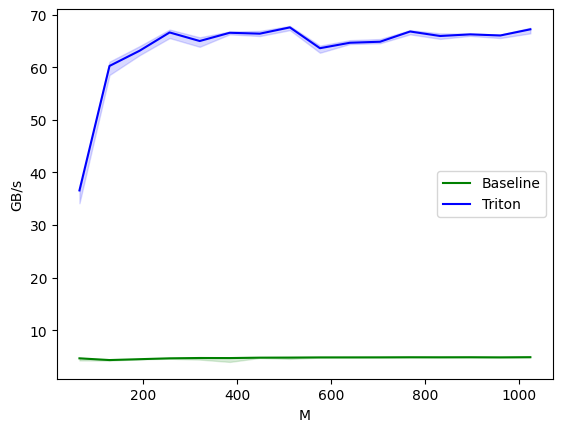

quant-rms-norm-forward:
         M       N  Baseline     Triton
0     64.0    64.0  4.654545  36.571428
1    128.0   128.0  4.325238  60.235293
2    192.0   192.0  4.491228  63.123285
3    256.0   256.0  4.654545  66.601623
4    320.0   320.0  4.717155  64.974619
5    384.0   384.0  4.704441  66.541513
6    448.0   448.0  4.781826  66.370371
7    512.0   512.0  4.796253  67.562887
8    576.0   576.0  4.830189  63.607360
9    640.0   640.0  4.833609  64.646467
10   704.0   704.0  4.840756  64.837258
11   768.0   768.0  4.859178  66.782607
12   832.0   832.0  4.851767  65.926096
13   896.0   896.0  4.862015  66.238943
14   960.0   960.0  4.839116  66.024287
15  1024.0  1024.0  4.873471  67.200256
Trial when shape = (4, 4, 64, 64) for baseline for backward pass
Trial when shape = (4, 4, 64, 64) for triton for backward pass
Triton autotuning for function quant_rms_norm_nd_bwd_kernel finished after 1.32s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial w

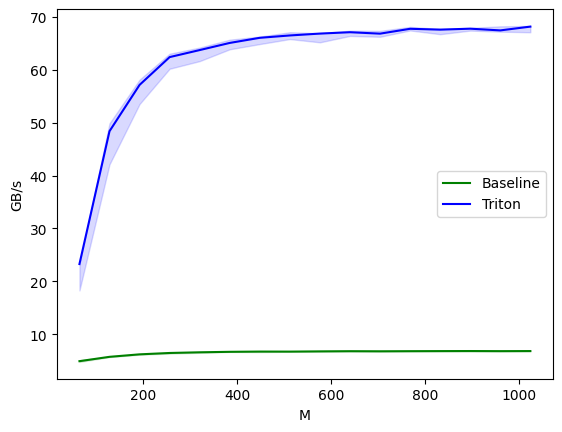

quant-rms-norm-backward:
         M       N  Baseline     Triton
0     64.0    64.0  4.923077  23.272727
1    128.0   128.0  5.742056  48.377950
2    192.0   192.0  6.210243  57.123968
3    256.0   256.0  6.469071  62.375634
4    320.0   320.0  6.597938  63.704696
5    384.0   384.0  6.687954  65.054117
6    448.0   448.0  6.733226  66.021056
7    512.0   512.0  6.726240  66.466533
8    576.0   576.0  6.771676  66.818476
9    640.0   640.0  6.806097  67.076985
10   704.0   704.0  6.787029  66.806614
11   768.0   768.0  6.809643  67.723210
12   832.0   832.0  6.824333  67.564811
13   896.0   896.0  6.836278  67.744377
14   960.0   960.0  6.815493  67.420992
15  1024.0  1024.0  6.831411  68.136546


In [59]:
# ruff: noqa: E731
@triton.testing.perf_report(configs)
def benchmark(M, N, provider, mode):
    x_shape = (4, 4, M, N)
    weight_shape = (x_shape[-1],)

    print(f"Trial when shape = {x_shape} for {provider} for {mode} pass")

    x = torch.rand(x_shape, device="cuda", requires_grad=True)
    gain = torch.rand(weight_shape, device="cuda", requires_grad=True)
    bias = torch.rand(weight_shape, device="cuda", requires_grad=True)
    dy = 0.1 * torch.randn_like(x)

    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == "baseline":
            return quant_rms_norm_baseline(x, gain, bias, 1e-5)
        if provider == "triton":
            return quant_rms_norm_triton(x, gain, bias, 1e-5)

    if mode == "forward":
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles)
    else:  # Backward
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dy, retain_graph=True), quantiles=quantiles, grad_to_none=[x]
        )

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)  # TODO: Re-enable